SAIDL 2024 Spring Assignment

Author: Shanay Mehta

**Packages:**

In [1]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import *
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

**Device:**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.random.manual_seed(1)
np.random.seed(1)

**Loading the CIFAR 10 Dataset:**

In [4]:
image_size = 32
transforms = {
    # Data augmentation and normalisation
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #normalise according to the
    ]),
    "test": Compose([
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )


100%|██████████| 170498071/170498071 [00:03<00:00, 43076635.59it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


**Display image**

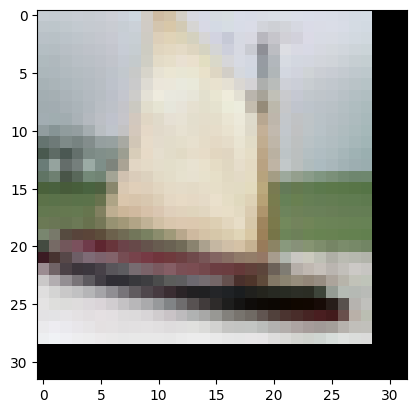

torch.Size([3, 32, 32])
tensor(8)


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# printing images
dataiter = iter(dataloader['train'])
images, labels = next(dataiter)

imshow(images[0])
print(images[0].shape)
print(labels[0])

**Train and Test functions**

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  l2_lambda: float = 0.005,
) -> float:
  model.train()

  total_loss = 0.0

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # L2 regularization
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    loss += 0.5 * l2_lambda * l2_reg

    total_loss += loss.item() * inputs.size(0)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()
  return total_loss/len(dataloader.dataset)

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

**VGG Model**

In [8]:
# Code for the VGG16 class has been taken from: https://blog.paperspace.com/vgg-from-scratch-pytorch/
# This is done because VGG16 is a standard model and it is not the main focus of this project
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(16*256, 1600),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(1600, 1000),
            nn.Dropout(0.5),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(1000, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [9]:
model = VGG16().to(device)

In [10]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [11]:
def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

In [12]:
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

In [13]:
model_size= get_model_size(model, data_width=32, count_nonzero_only=False)/(8*1024*1024)
print(f"Model size: {model_size:.2f} MiB")

Model size: 37.78 MiB


In [14]:
# Save the model to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
weights_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'

**Training the model**

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

weights_history = []
accuracy_history = []
loss_history = []

num_epochs = 60
best_accuracy = 0.0

for epoch in range(num_epochs):
    loss = train(model, dataloader['train'], criterion, optimizer)
    accuracy = evaluate(model, dataloader['test'])

    if accuracy > best_accuracy:
        torch.save(model.state_dict(), weights_path)
        best_accuracy = accuracy

    if epoch == 19:
      optimizer = Adam(model.parameters(), lr=0.0005) # Based on observation

    elif epoch == 39:
      optimizer = Adam(model.parameters(), lr=0.0001) # Based on observation

    print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%, Train Loss: {loss:.4f}")

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/60, Test Accuracy: 29.14%, Train Loss: 5.9903


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/60, Test Accuracy: 48.46%, Train Loss: 4.1051


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/60, Test Accuracy: 59.63%, Train Loss: 3.3438


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/60, Test Accuracy: 58.34%, Train Loss: 2.8566


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/60, Test Accuracy: 64.85%, Train Loss: 2.4614


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/60, Test Accuracy: 60.56%, Train Loss: 2.1450


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/60, Test Accuracy: 71.06%, Train Loss: 1.8952


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/60, Test Accuracy: 71.26%, Train Loss: 1.7023


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/60, Test Accuracy: 71.13%, Train Loss: 1.5383


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/60, Test Accuracy: 71.77%, Train Loss: 1.4202


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/60, Test Accuracy: 75.24%, Train Loss: 1.3311


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/60, Test Accuracy: 76.29%, Train Loss: 1.2440


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/60, Test Accuracy: 67.82%, Train Loss: 1.1784


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/60, Test Accuracy: 74.70%, Train Loss: 1.1253


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/60, Test Accuracy: 74.22%, Train Loss: 1.0881


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/60, Test Accuracy: 76.27%, Train Loss: 1.0581


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/60, Test Accuracy: 79.25%, Train Loss: 1.0250


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/60, Test Accuracy: 74.89%, Train Loss: 1.0058


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/60, Test Accuracy: 82.08%, Train Loss: 0.9895


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/60, Test Accuracy: 74.35%, Train Loss: 0.9657


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/60, Test Accuracy: 86.29%, Train Loss: 0.8486


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/60, Test Accuracy: 84.61%, Train Loss: 0.7835


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/60, Test Accuracy: 78.97%, Train Loss: 0.7572


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/60, Test Accuracy: 83.14%, Train Loss: 0.7322


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/60, Test Accuracy: 83.15%, Train Loss: 0.7192


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/60, Test Accuracy: 87.28%, Train Loss: 0.7048


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/60, Test Accuracy: 87.01%, Train Loss: 0.7106


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/60, Test Accuracy: 84.93%, Train Loss: 0.6918


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/60, Test Accuracy: 86.50%, Train Loss: 0.6753


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/60, Test Accuracy: 85.37%, Train Loss: 0.6695


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/60, Test Accuracy: 84.72%, Train Loss: 0.6674


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/60, Test Accuracy: 84.51%, Train Loss: 0.6613


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/60, Test Accuracy: 86.45%, Train Loss: 0.6564


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/60, Test Accuracy: 85.76%, Train Loss: 0.6473


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/60, Test Accuracy: 85.59%, Train Loss: 0.6437


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/60, Test Accuracy: 85.68%, Train Loss: 0.6363


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/60, Test Accuracy: 86.64%, Train Loss: 0.6348


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/60, Test Accuracy: 84.37%, Train Loss: 0.6391


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/60, Test Accuracy: 86.84%, Train Loss: 0.6263


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/60, Test Accuracy: 86.91%, Train Loss: 0.6207


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/60, Test Accuracy: 90.78%, Train Loss: 0.5305


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/60, Test Accuracy: 90.71%, Train Loss: 0.4946


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/60, Test Accuracy: 91.07%, Train Loss: 0.4754


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/60, Test Accuracy: 90.44%, Train Loss: 0.4596


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/60, Test Accuracy: 90.73%, Train Loss: 0.4509


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/60, Test Accuracy: 91.09%, Train Loss: 0.4434


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/60, Test Accuracy: 90.64%, Train Loss: 0.4366


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/60, Test Accuracy: 90.48%, Train Loss: 0.4259


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/60, Test Accuracy: 90.77%, Train Loss: 0.4182


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/60, Test Accuracy: 90.25%, Train Loss: 0.4152


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/60, Test Accuracy: 90.83%, Train Loss: 0.4103


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/60, Test Accuracy: 90.17%, Train Loss: 0.4024


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/60, Test Accuracy: 90.87%, Train Loss: 0.3941


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/60, Test Accuracy: 90.06%, Train Loss: 0.3920


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/60, Test Accuracy: 90.76%, Train Loss: 0.3882


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/60, Test Accuracy: 90.61%, Train Loss: 0.3838


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/60, Test Accuracy: 90.34%, Train Loss: 0.3802


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/60, Test Accuracy: 90.83%, Train Loss: 0.3720


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/60, Test Accuracy: 90.42%, Train Loss: 0.3701


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/60, Test Accuracy: 90.70%, Train Loss: 0.3691


In [18]:
# Load the saved model
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


In [19]:
accuracy = evaluate(loaded_model, dataloader['test'])
print(f"Test Accuracy: {accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 91.09%


**Pruning**

In [20]:
def prune_layer(model: nn.Module, layer_name: str, prune_percent: float):
    """
    Prune a specified percentage of weights in a layer using argmin method.
    :param model: The model to be pruned.
    :param layer_name: The name of the layer to be pruned.
    :param prune_percent: The percentage of weights to be pruned.
    """
    layer = getattr(model, layer_name)
    weights = layer[0].weight.data # I have only pruned the weights of layer[0] because it contains the majority of weights for that particular layer
    num_weights = weights.numel()
    num_prune = int(num_weights * prune_percent)
    flat_weights = weights.view(-1)
    _, indices = torch.topk(torch.abs(flat_weights), num_prune, largest=False)
    flat_weights[indices] = 0.0
    weights.data = flat_weights.view(weights.size())

**Sensitivity Scan**

In [22]:
# Plot accuracy vs. pruning percentage for all layers
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'fc', 'fc1', 'fc2']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'brown']
prune_per = list(range(0, 91, 10))
accuracy_values = [[] for _ in range(len(layer_names))]

for layer_idx, layer_name in enumerate(layer_names):
    for prune_percent in prune_per:
        # Load the saved model
        load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
        loaded_model = VGG16().to(device)
        loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
        print(f"Model loaded from {load_path}")
        # Prune the specified percentage of the layer
        prune_layer(loaded_model, layer_name, prune_percent / 100.0)
        # Evaluate the pruned model
        accuracy = evaluate(loaded_model, dataloader['test'])
        print(f"Test Accuracy with {prune_percent}% pruning for {layer_name}: {accuracy:.2f}%")
        accuracy_values[layer_idx].append(accuracy)


Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer1: 91.08%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer1: 90.98%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer1: 90.15%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer1: 89.70%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer1: 84.50%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer1: 78.01%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer1: 68.08%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer1: 46.99%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer1: 19.67%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer2: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer2: 91.12%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer2: 91.10%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer2: 90.95%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer2: 90.94%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer2: 90.67%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer2: 90.59%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer2: 89.93%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer2: 86.58%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer2: 76.20%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer3: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer3: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer3: 91.11%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer3: 91.04%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer3: 91.02%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer3: 90.65%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer3: 90.04%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer3: 89.28%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer3: 87.16%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer3: 78.46%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer4: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer4: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer4: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer4: 91.12%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer4: 91.10%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer4: 91.12%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer4: 90.63%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer4: 89.68%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer4: 88.20%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer4: 80.57%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer5: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer5: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer5: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer5: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer5: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer5: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer5: 91.15%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer5: 91.17%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer5: 90.97%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer5: 89.10%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer6: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for layer7: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for layer7: 91.11%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for fc: 91.10%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for fc: 91.12%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for fc: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for fc1: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for fc1: 91.04%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 0% pruning for fc2: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 10% pruning for fc2: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 20% pruning for fc2: 91.09%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 30% pruning for fc2: 91.10%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 40% pruning for fc2: 91.13%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 50% pruning for fc2: 91.11%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 60% pruning for fc2: 90.95%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 70% pruning for fc2: 90.82%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 80% pruning for fc2: 90.49%
Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with 90% pruning for fc2: 87.29%


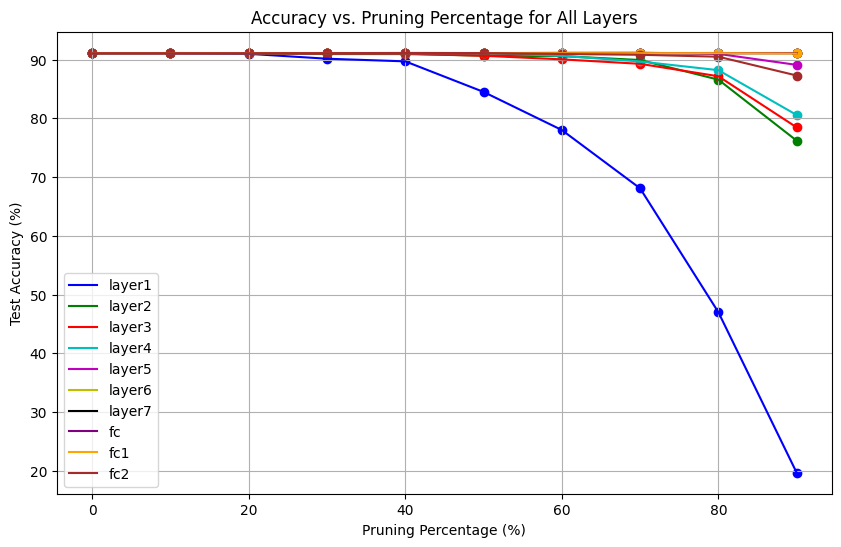

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
for layer_idx, layer_name in enumerate(layer_names):
    plt.plot(prune_per, accuracy_values[layer_idx], color=colors[layer_idx], label=layer_name)

for layer_idx, layer_name in enumerate(layer_names):
    plt.scatter(prune_per, accuracy_values[layer_idx], color=colors[layer_idx])

plt.xlabel('Pruning Percentage (%)')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs. Pruning Percentage for All Layers')
plt.legend()
plt.grid(True)
plt.show()

Modified the prune_layer function to return mask of the parameters pruned

In [24]:
def prune_layer_mod(model: nn.Module, layer_name: str, prune_percent: float):
    """
    Prune a specified percentage of weights in a layer using argmin method.
    :param model: The model to be pruned.
    :param layer_name: The name of the layer to be pruned.
    :param prune_percent: The percentage of weights to be pruned.
    """
    layer = getattr(model, layer_name)
    weights = layer[0].weight.data
    num_weights = weights.numel()
    num_prune = int(num_weights * prune_percent)
    flat_weights = weights.view(-1)
    _, indices = torch.topk(torch.abs(flat_weights), num_prune, largest=False)
    flat_weights[indices] = 0.0
    mask = torch.ones_like(flat_weights)
    # Set 0s at indices to be pruned
    mask[indices] = 0.0
    weights.data = flat_weights.view(weights.size())
    mask = mask.view(weights.size())
    return mask

In [25]:
load_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth'
loaded_model = VGG16().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/weights_history.pth


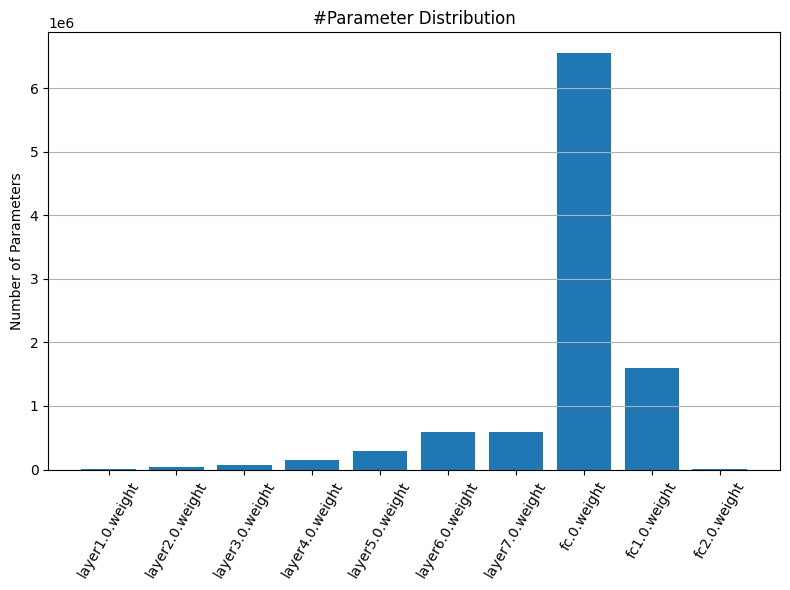

In [26]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(loaded_model)

**Criteria for selecting how much of each layer to prune**:

1. **Accuracy**: We need to ensure that accuracy of the pruned model does not drop below a certain threshold(decide based on sensitivity scan)

2. **Percentage of params in the layer**: A layer which contains a very small percentage of params(percentage taken w.r.t the number of params in the entire model) should not be pruned much since it wont have a big effect on the model size. However, a layer which accounts for a big percentage should be pruned as much as possible. This leads to the conclusion that fully connected layers should be pruned more as compared to conv layers

**Pruning the loaded model**

In [27]:
masks = dict()
masks['layer1.0.weight'] = prune_layer_mod(loaded_model, 'layer1', 0.0 / 100.0)
masks['layer2.0.weight'] = prune_layer_mod(loaded_model, 'layer2', 0.0 / 100.0)
masks['layer3.0.weight'] = prune_layer_mod(loaded_model, 'layer3', 0.0 / 100.0)
masks['layer4.0.weight'] = prune_layer_mod(loaded_model, 'layer4', 0.0 / 100.0)
masks['layer5.0.weight'] = prune_layer_mod(loaded_model, 'layer5', 90.0 / 100.0)
masks['layer6.0.weight'] = prune_layer_mod(loaded_model, 'layer6', 90.0 / 100.0)
masks['layer7.0.weight'] = prune_layer_mod(loaded_model, 'layer7', 90.0 / 100.0)
masks['fc.0.weight'] = prune_layer_mod(loaded_model, 'fc', 95.0 / 100.0)
masks['fc1.0.weight'] = prune_layer_mod(loaded_model, 'fc1', 95.0 / 100.0)
masks['fc2.0.weight'] = prune_layer_mod(loaded_model, 'fc2', 90.0 / 100.0)

In [28]:
model_size= get_model_size(loaded_model, data_width=32, count_nonzero_only=True)/(8*1024*1024)
print(f"Pruned model size: {model_size:.2f} MiB")

Pruned model size: 3.14 MiB


In [29]:
# Evaluate the pruned model
accuracy = evaluate(loaded_model, dataloader['test'])
print(f"Test Accuracy with pruned model of size {model_size:.2f} MiB: {accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy with pruned model of size 3.14 MiB: 85.22%


*Note: The model size was initially 37.78 MiB with an accuracy of 91.09% and the size of the pruned model is 3.14 MiB(Approximately 10 times smaller) with an accuracy of 85.22%. **

The reduction in size of the model is huge however the reduction in accuracy is very small. This is because the percentage of pruning for each layer has been carefully chosen based on the factors listed above.

**Fine-Tuning**

Modify the train function to include masks for fine-tuning without affecting the pruned synapses

In [30]:
def train_ft(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  l2_lambda: float = 0.005,
  callbacks = None
) -> float:
  model.train()

  total_loss = 0.0

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # L2 regularization
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    loss += 0.5 * l2_lambda * l2_reg

    total_loss += loss.item() * inputs.size(0)

    # Backward propagation
    loss.backward()
    # Apply the mask to the gradients
    for name, param in model.named_parameters():
      # print(f"Name: {name}")
      # print(f"Param: {param}")
      # print(f"Param grad: {param.grad}")

      if name in masks:
        # print(f"mask: {masks[name]}")
        param.grad *= masks[name]
        # print(f"Param grad: {param.grad}")

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()
  return total_loss/len(dataloader.dataset)

In [31]:
pruned_weights_path = '/content/drive/MyDrive/SAIDL_2024_Assignment/Pruning/pru_weights_history.pth'

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(loaded_model.parameters(), lr=0.00001) # learning has been made 1/10th of its previous value

best_accuracy = 0.0
num_epochs = 30
print(f"Test Accuracy before fine-tuning: {accuracy:.2f}%")
for epoch in range(num_epochs):
    loss = train_ft(loaded_model, dataloader['train'], criterion, optimizer)
    accuracy = evaluate(loaded_model, dataloader['test'])

    if accuracy > best_accuracy:
        torch.save(model.state_dict(), pruned_weights_path)
        best_accuracy = accuracy

    print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.2f}%, Train Loss: {loss:.4f}")
    model_size= get_model_size(loaded_model, data_width=32, count_nonzero_only=True)/(8*1024*1024)
    print(f"Pruned model size: {model_size:.2f} MiB") # To test that fine-tuning is not affecting any pruned weights

Test Accuracy before fine-tuning: 85.22%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/30, Test Accuracy: 90.35%, Train Loss: 0.8959
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/30, Test Accuracy: 90.77%, Train Loss: 0.7526
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/30, Test Accuracy: 90.96%, Train Loss: 0.6693
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/30, Test Accuracy: 91.04%, Train Loss: 0.6154
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/30, Test Accuracy: 91.16%, Train Loss: 0.5788
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/30, Test Accuracy: 91.29%, Train Loss: 0.5565
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/30, Test Accuracy: 91.34%, Train Loss: 0.5363
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/30, Test Accuracy: 91.31%, Train Loss: 0.5247
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/30, Test Accuracy: 91.35%, Train Loss: 0.5139
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/30, Test Accuracy: 91.37%, Train Loss: 0.5053
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/30, Test Accuracy: 91.43%, Train Loss: 0.4990
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/30, Test Accuracy: 91.45%, Train Loss: 0.4935
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/30, Test Accuracy: 91.59%, Train Loss: 0.4904
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/30, Test Accuracy: 91.42%, Train Loss: 0.4840
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/30, Test Accuracy: 91.57%, Train Loss: 0.4797
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/30, Test Accuracy: 91.52%, Train Loss: 0.4774
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/30, Test Accuracy: 91.35%, Train Loss: 0.4729
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/30, Test Accuracy: 91.46%, Train Loss: 0.4695
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/30, Test Accuracy: 91.57%, Train Loss: 0.4692
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/30, Test Accuracy: 91.53%, Train Loss: 0.4661
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/30, Test Accuracy: 91.51%, Train Loss: 0.4629
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/30, Test Accuracy: 91.53%, Train Loss: 0.4600
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/30, Test Accuracy: 91.46%, Train Loss: 0.4575
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/30, Test Accuracy: 91.51%, Train Loss: 0.4568
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/30, Test Accuracy: 91.35%, Train Loss: 0.4547
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/30, Test Accuracy: 91.34%, Train Loss: 0.4525
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/30, Test Accuracy: 91.46%, Train Loss: 0.4509
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/30, Test Accuracy: 91.49%, Train Loss: 0.4476
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/30, Test Accuracy: 91.47%, Train Loss: 0.4470
Pruned model size: 3.14 MiB


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/30, Test Accuracy: 91.47%, Train Loss: 0.4431
Pruned model size: 3.14 MiB


After fine-tuning, we obtain an accuracy better than the accuracy of the un-pruned model. This may be because of the lower learning rate used.

Another key thing to note is that accuracy has platued aroung 91.3% from epoch 7. This suggests that the model is capable of obtaining an even better accuracy. This can be achieved using a lr scheduler with ReduceLROnPlateau.